In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_images_and_generate_masks(base_dir, img_size=(64, 64)):
    images = []
    masks = []

    # Loop through Cancerous and Non Cancerous folders
    for category in ["Cancerous", "Non Cancerous"]:
        category_path = os.path.join(base_dir, category)

        # Loop through subfolders
        for sub_class in os.listdir(category_path):
            sub_class_path = os.path.join(category_path, sub_class)
            for filename in os.listdir(sub_class_path):
                img_path = os.path.join(sub_class_path, filename)
                
                # Read image in grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                
                # Resize image
                img = cv2.resize(img, img_size)
                norm_img = img / 255.0  # Normalize

                # Generate pseudo-mask using Otsu threshold
                _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                mask = mask / 255.0  # Normalize mask
                mask = np.expand_dims(mask, axis=-1)

                images.append(norm_img)
                masks.append(mask)

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    masks = np.array(masks)

    return images, masks

In [3]:
train_dir = "/kaggle/input/skin-cancer-images/Train/Train"
val_dir = "/kaggle/input/skin-cancer-images/Val/Val"

x_train, y_train = load_images_and_generate_masks(train_dir)
x_val, y_val = load_images_and_generate_masks(val_dir)

In [4]:
print("Train Images:", x_train.shape)
print("Train Masks:", y_train.shape)
print("Val Images:", x_val.shape)
print("Val Masks:", y_val.shape)

Train Images: (32966, 64, 64, 1)
Train Masks: (32966, 64, 64, 1)
Val Images: (14132, 64, 64, 1)
Val Masks: (14132, 64, 64, 1)


In [ ]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(64, 64, 1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(b)
    u1 = layers.Dropout(0.3)(u1)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    u2 = layers.Dropout(0.3)(u2)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    return models.Model(inputs, outputs)

2025-07-21 18:10:35.598481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753121435.799403      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753121435.855981      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1753121448.091383      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753121448.092025      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5


I0000 00:00:1753121457.298350     105 service.cc:148] XLA service 0x7e9d64006a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753121457.299030     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753121457.299051     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753121457.883172     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/1031 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.7230 - loss: 0.6576   

I0000 00:00:1753121463.998798     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1031/1031 ━━━━━━━━━━━━━━━━━━━━ 52s 39ms/step - accuracy: 0.8747 - loss: 0.2896 - val_accuracy: 0.9320 - val_loss: 0.1605
Epoch 2/5
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - accuracy: 0.9372 - loss: 0.1506 - val_accuracy: 0.9466 - val_loss: 0.1289
Epoch 3/5
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.9443 - loss: 0.1331 - val_accuracy: 0.9485 - val_loss: 0.1231
Epoch 4/5
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.9474 - loss: 0.1256 - val_accuracy: 0.9507 - val_loss: 0.1179
Epoch 5/5
1031/1031 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.9489 - loss: 0.1219 - val_accuracy: 0.9424 - val_loss: 0.1326


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


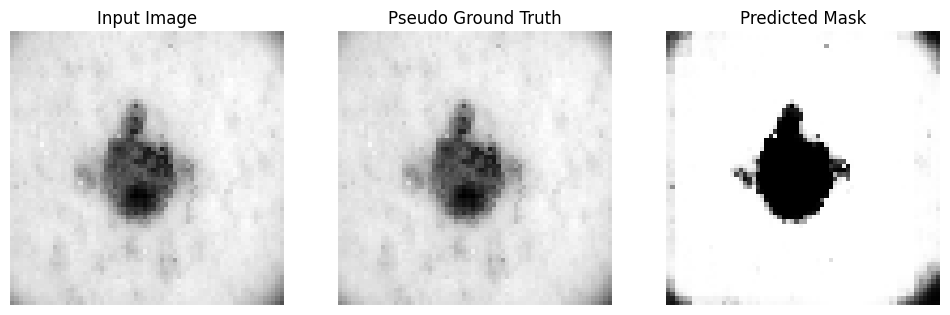

In [10]:
import matplotlib.pyplot as plt

def visualize_sample(img, mask, pred):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title('Input Image')

    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title('Pseudo Ground Truth')

    axs[2].imshow(pred.squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')

    for ax in axs:
        ax.axis('off')

sample = x_val[0:1]
pred = model.predict(sample)

visualize_sample(sample[0], x_val[0], pred[0])

In [24]:
model.save('/kaggle/working/unet_model.h5')

In [25]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#  use U-Net to predict the segmentation mask for each input image.
def segment_image(unet_model, image):
    image = image / 255.0
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    mask = unet_model.predict(image, verbose=0)[0]
    return (mask > 0.5).astype(np.uint8)[..., 0]

# auto-crop the lesion or highlight the important area
def extract_roi_from_mask(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cv2.resize(image, (64, 64))
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    roi = image[y:y+h, x:x+w]
    return cv2.resize(roi, (64, 64))

In [26]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_dataset(unet_model, base_dir):
    X = []
    y = []

    for label, folder in enumerate(["Non Cancerous", "Cancerous"]):
        class_dir = os.path.join(base_dir, folder)

        for subfolder in os.listdir(class_dir):
            subfolder_path = os.path.join(class_dir, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            for fname in tqdm(os.listdir(subfolder_path), desc=f"{folder}/{subfolder}"):
                fpath = os.path.join(subfolder_path, fname)

                try:
                    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        raise ValueError("Failed to load image.")

                    img = cv2.resize(img, (64, 64))

                    # Segment the lesion using U-Net
                    mask = segment_image(model, img)

                    # Extract ROI from segmented mask
                    roi = extract_roi_from_mask(img, mask)

                    X.append(roi)
                    y.append(label)

                except Exception as e:
                    print(f"Skipped {fpath}: {e}")

    X = np.array(X).reshape(-1, 64, 64, 1) / 255.0
    y = np.array(y)

    return X, y


In [27]:
train_dir = "/kaggle/input/skin-cancer-images/Train/Train"
val_dir = "/kaggle/input/skin-cancer-images/Val/Val"

X_train, y_train = preprocess_dataset(unet_model, train_dir)
X_val, y_val = preprocess_dataset(unet_model, val_dir)

Cancerous/malignant: 100%|██████████| 3836/3836 [05:00<00:00, 12.75it/s]


In [28]:
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (32966, 64, 64, 1) (32966,)
Val: (14132, 64, 64, 1) (14132,)


In [29]:
import os
import cv2

def save_images(images, labels, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for i, (img, label) in enumerate(zip(images, labels)):
        label_folder = "Cancerous" if label == 1 else "Non_Cancerous"
        folder_path = os.path.join(save_dir, label_folder)
        os.makedirs(folder_path, exist_ok=True)
        
        # Convert from float to uint8
        img_uint8 = (img.squeeze() * 255).astype('uint8')
        save_path = os.path.join(folder_path, f"image_{i}.png")
        cv2.imwrite(save_path, img_uint8)

# Save train and val images
save_images(X_train, y_train, "/kaggle/working/processed_train")
save_images(X_val, y_val, "/kaggle/working/processed_val")

In [ ]:
import shutil

# Zip the processed_train folder
shutil.make_archive("/kaggle/working/processed_train", 'zip', "/kaggle/working/processed_train")

# Zip the processed_val folder
shutil.make_archive("/kaggle/working/processed_val", 'zip', "/kaggle/working/processed_val")
